. # Applied Data Science 2 - Keras Assignment - 2023A

In this assignment you will be building a script to classify movie posters. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

In [ ]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection

In [ ]:
# CodeGrade Tag Init1
# Do not edit, remove, or copy this cell

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


# Data Processing



In [ ]:
# CodeGrade Tag Init2
# Do not edit, remove, or copy this cell

# This code will copy the images from your google drive into the colab file
# storage. Make sure the dataset is unzipped in your drive folder.
! mkdir /Multi_Label_dataset
! rsync -ah --info=progress2 /content/drive/MyDrive/Colab_Notebooks/Multi_Label_dataset/Multi_Label_dataset/Images /Multi_Label_dataset/


mkdir: cannot create directory ‘/Multi_Label_dataset’: File exists
              0   0%    0.00kB/s    0:00:00 (xfr#0, to-chk=0/7871)   


In [ ]:
# CodeGrade Tag DataProc
# Do not edit, remove, or copy this cell

# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Colab Notebooks/Multi_Label_dataset/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Multi_Label_dataset/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [ ]:
# CodeGrade Tag Ex1a
### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64, 64), and finally returns the image and labels.
def img_process(image, label):
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    # Resize the image to (64, 64)
    image = tf.image.resize(image, (64, 64))
    return image, label


**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:
# CodeGrade Tag Ex1b
### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 64. Use techniques like caching and
### prefetching to efficiently load the data.

# Set batch size
batch_size = 64

# Apply parse_image and img_process functions to train and test datasets
train_ds = train_list_ds.map(parse_image).map(img_process).cache().shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_list_ds.map(parse_image).map(img_process).batch(batch_size).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a Sigmoid activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.
* For the dropout layers, use a dropout rate of 0.2 after the convolutional layers and 0.5 after the dense layers.


```
# Model Summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928     
                                                                 
 Drop3 (Dropout)             (None, 16, 16, 64)        0         
                                                                 
 Pool2 (MaxPooling2D)        (None, 8, 8, 64)          0         
                                                                 
 Conv5 (Conv2D)              (None, 8, 8, 128)         73856     
                                                                 
 Conv6 (Conv2D)              (None, 8, 8, 128)         147584    
                                                                 
 Drop4 (Dropout)             (None, 8, 8, 128)         0         
                                                                 
 Pool3 (MaxPooling2D)        (None, 4, 4, 128)         0         
                                                                 
 Flat (Flatten)              (None, 2048)              0         
                                                                 
 FC1 (Dense)                 (None, 1024)              2098176   
                                                                 
 Drop5 (Dropout)             (None, 1024)              0         
                                                                 
 FC2 (Dense)                 (None, 1024)              1049600   
                                                                 
 Drop6 (Dropout)             (None, 1024)              0         
                                                                 
 Output (Dense)              (None, 25)                25625     
                                                                 
=================================================================
Total params: 3464601 (13.22 MB)
Trainable params: 3464601 (13.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


```



In [ ]:
# CodeGrade Tag Ex2a
### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.

from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense

# Define the input layer
input_layer = Input(shape=(64, 64, 3), name='Input')

# Convolutional layers
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same', name='Conv0')(input_layer)
drop1 = Dropout(0.2, name='Drop1')(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv1')(drop1)
conv3 = Conv2D(32, (3, 3), activation='relu', padding='same', name='Conv2')(conv2)
drop2 = Dropout(0.2, name='Drop2')(conv3)
pool1 = MaxPooling2D((2, 2), name='Pool1')(drop2)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv3')(pool1)
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv4')(conv4)
drop3 = Dropout(0.2, name='Drop3')(conv5)
pool2 = MaxPooling2D((2, 2), name='Pool2')(drop3)
conv6 = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv5')(pool2)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv6')(conv6)
drop4 = Dropout(0.2, name='Drop4')(conv7)
pool3 = MaxPooling2D((2, 2), name='Pool3')(drop4)

# Flatten layer
flatten = Flatten(name='Flat')(pool3)

# Dense layers
fc1 = Dense(1024, activation='relu', name='FC1')(flatten)
drop5 = Dropout(0.5, name='Drop5')(fc1)
fc2 = Dense(1024, activation='relu', name='FC2')(drop5)
drop6 = Dropout(0.5, name='Drop6')(fc2)

# Output layer
output_layer = Dense(25, activation='sigmoid', name='Output')(drop6)

# Define the model
model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model')




In [ ]:
# CodeGrade Tag Ex2b
### Print the model summary and confirm is has the same architecture as the one
### provided.

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 64, 64, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 64, 64, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 64, 64, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 64, 64, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 64, 64, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 32, 32, 32)        0     

**Compile the model using the Adam Optimizer with a learning rate of ```1e-4``` and ```binary crossentropy``` loss function. For the metrics, use the ``Precision`` and ``Recall`` functions.**

In [ ]:
# CodeGrade Tag Ex2c
### Compile the model using the Adam Optimizer, binary crossentropy loss, and
### precision and recall metrics.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])


# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/checkpoint/'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


In [ ]:
import os

# Check if the weights file has been created
file_exists = os.path.exists('/content/checkpoint/best_model.h5')
print("Model weights were saved:", file_exists)


Model weights were saved: False


**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:
# CodeGrade Tag Ex3b
### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

# Define the LearningRateScheduler callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


**Train the model for 40 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:
# CodeGrade Tag Ex3c
### Train the model for 40 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

# Define the number of epochs
epochs = 40

# Train the model
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=test_ds,
    callbacks=[checkpoint_callback, lr_callback]
)




Epoch 1/40
91/91 [==============================] - ETA: 0s - loss: 0.3614 - precision: 0.4005 - recall: 0.1742 - accuracy: 0.2347
Epoch 1: val_accuracy improved from -inf to 0.18952, saving model to /content/checkpoint/
91/91 [==============================] - 19s 85ms/step - loss: 0.3614 - precision: 0.4005 - recall: 0.1742 - accuracy: 0.2347 - val_loss: 0.3014 - val_precision: 0.5725 - val_recall: 0.0695 - val_accuracy: 0.1895 - lr: 0.0010
Epoch 2/40
91/91 [==============================] - ETA: 0s - loss: 0.2484 - precision: 0.5079 - recall: 0.1824 - accuracy: 0.2761
Epoch 2: val_accuracy improved from 0.18952 to 0.30255, saving model to /content/checkpoint/
91/91 [==============================] - 4s 43ms/step - loss: 0.2484 - precision: 0.5079 - recall: 0.1824 - accuracy: 0.2761 - val_loss: 0.2889 - val_precision: 0.6086 - val_recall: 0.1187 - val_accuracy: 0.3025 - lr: 0.0010
Epoch 3/40
91/91 [==============================] - ETA: 0s - loss: 0.2431 - precision: 0.5380 - recall:

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

Available history keys:  dict_keys(['loss', 'precision', 'recall', 'accuracy', 'val_loss', 'val_precision', 'val_recall', 'val_accuracy', 'lr'])


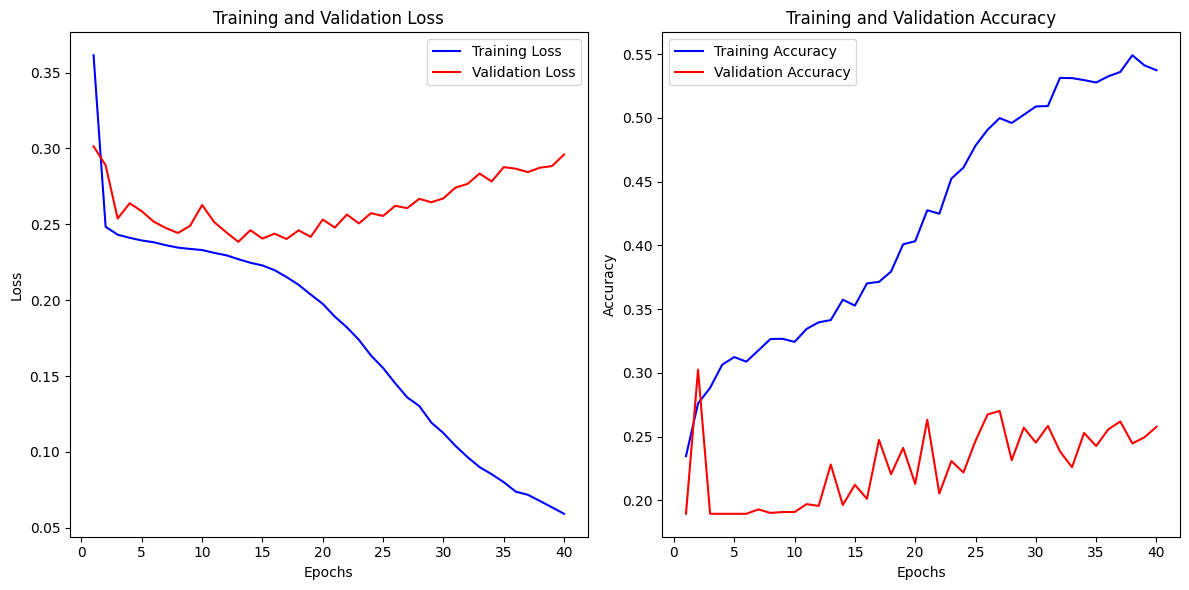

In [ ]:
import matplotlib.pyplot as plt

# Check the available keys in the history object
print("Available history keys: ", history.history.keys())

# Safe access to the metrics
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
accuracy = history.history.get('accuracy', history.history.get('acc', []))
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc', []))
epochs = range(1, len(loss) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
if accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()


**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce of the model. Be sure to demonstrate the results of the multi-label classification, comparing the top three most probable genres predicted with the ground truth genres for each poster. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

In [ ]:
pip install pyyaml h5py

In [ ]:
model.save_weights(checkpoint_filepath)


In [ ]:
# Load the weights correctly by specifying the complete path to the checkpoint prefix
model.load_weights(checkpoint_filepath)


In [ ]:
# Get predictions for the test dataset
predictions = model.predict(test_ds)


23/23 [==============================] - 0s 9ms/step


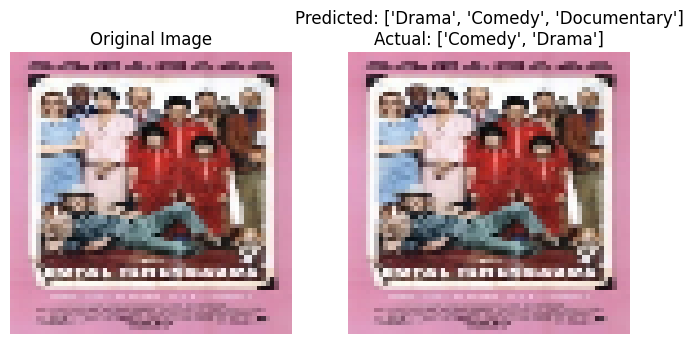

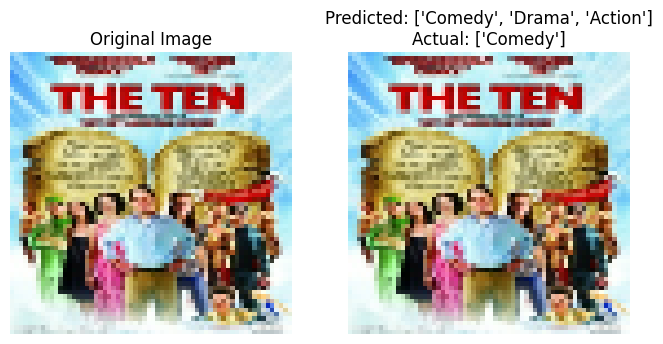

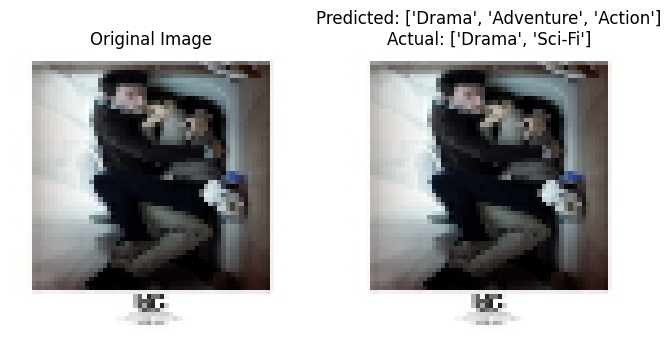

In [ ]:
import numpy as np

def get_top_n_predictions(predictions, n=3):
    # Args:
    # predictions: numpy array of predictions
    # n: number of top elements to retrieve
    # Returns: indices of top n predictions
    return np.argsort(-predictions, axis=1)[:, :n]

for images, labels in test_ds.take(1):
    top_pred_indices = get_top_n_predictions(predictions, 3)
    actual_labels = labels.numpy()

    for i in range(3):
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Original Image")
        plt.axis("off")

        predicted_labels = [genres[idx] for idx in top_pred_indices[i]]
        actual_genres = [genres[idx] for idx in np.where(actual_labels[i] == 1)[0]]

        plt.subplot(1, 2, 2)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Predicted: {predicted_labels}\nActual: {actual_genres}")
        plt.axis("off")
        plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Convert the predictions and labels into appropriate binary format for all genres
binary_predictions = (predictions > 0.5).astype(int)  # This threshold of 0.5 can be adjusted
actual_labels = np.vstack([y for x, y in test_ds.unbatch()])  # Stacking labels

print(classification_report(actual_labels, binary_predictions, target_names=genres))


              precision    recall  f1-score   support

      Action       0.31      0.18      0.23       262
   Adventure       0.17      0.07      0.10       164
   Animation       0.38      0.10      0.16        51
   Biography       0.07      0.01      0.02        86
      Comedy       0.65      0.43      0.52       565
       Crime       0.21      0.07      0.11       246
 Documentary       0.14      0.08      0.10       139
       Drama       0.55      0.72      0.62       716
      Family       0.00      0.00      0.00        78
     Fantasy       0.11      0.03      0.05        94
     History       0.00      0.00      0.00        49
      Horror       0.29      0.28      0.28       105
       Music       0.14      0.02      0.03        66
     Musical       0.00      0.00      0.00        18
     Mystery       0.17      0.06      0.09        97
         N/A       0.00      0.00      0.00         1
        News       0.00      0.00      0.00         5
  Reality-TV       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 [==============================] - 1s 7ms/step


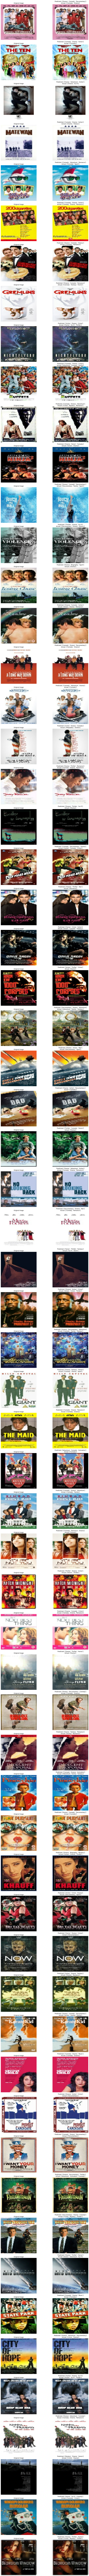

In [ ]:


for images, labels in test_ds.take(1):
    preds = model.predict(images)
    top_preds = np.argsort(-preds, axis=1)[:, :3]

    plt.figure(figsize=(15, 5 * len(images)))
    for i, (image, label) in enumerate(zip(images, labels)):
        # Plotting the original image
        plt.subplot(len(images), 2, 2 * i + 1)
        plt.imshow(image.numpy().astype('uint8'))
        plt.title('Original Image')
        plt.axis('off')

        # Plotting the image with predictions
        plt.subplot(len(images), 2, 2 * i + 2)
        predicted_labels = [genres[idx] for idx in top_preds[i]]
        actual_labels = [genres[idx] for idx, val in enumerate(label) if val == 1]
        plt.imshow(image.numpy().astype('uint8'))
        plt.title(f'Predicted: {predicted_labels}\nActual: {actual_labels}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
